# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = 'gdrive/My Drive/MLBD - Lernnavi Data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score, balanced_accuracy_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Task 0: Research Question

**Research question:**
*Predicting user motivation and retention. E.g., dropout or long pauses prediction, level checks prediction (self-supervised learning)*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [ ]:
# Create date column
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
events["week"] = events["date"].dt.isocalendar().week
events["year"] = events["date"].dt.year

In [ ]:
# User activity per week
df_weekly = events[["user_id","year","week"]].dropna().groupby(["user_id","year","week"]).size().reset_index(name='num_events')
df_weekly

,user_id,year,week,num_events
0,387604,2021,20,1
1,387604,2021,21,1
2,387604,2021,25,7
3,387604,2021,26,25
4,387604,2021,31,12
...,...,...,...,...
27527,404600,2022,8,34
27528,404603,2022,8,112
27529,404604,2022,8,43
27530,404605,2022,8,22


In [ ]:
# Number of questions answered and the evaluations per week
all_questions = events[["user_id","year","week","action","transaction_token"]].dropna()
all_questions = all_questions[all_questions['action']=='SUBMIT_ANSWER']

evaluations = all_questions.merge(transactions[['transaction_token', 'evaluation']].dropna().replace(["CORRECT","PARTIAL","WRONG"],[1,0.5,0]),
                                  on='transaction_token',
                                  how='left')

# Remove users that have a transaction in the event table that is not in the transaction table (~27000 / 400000)
evaluations = evaluations[evaluations['evaluation'].notna()]
num_questions = evaluations.drop(columns = ["transaction_token"]).groupby(
    ["user_id","year","week"]).size().reset_index(name='num_questions')
evaluations_count = evaluations.drop(columns = ["transaction_token"]).groupby(
    ["user_id","year","week"]).sum().reset_index()

df_questions = num_questions.merge(evaluations_count, on=['user_id', 'year', 'week'], how='left')
df_questions['percentage_correct'] = df_questions['evaluation'] / df_questions['num_questions']
df_questions = df_questions.drop(columns='evaluation')
df_questions

,user_id,year,week,num_questions,percentage_correct
0,387604,2021,35,1,0.000000
1,387604,2021,38,4,0.125000
2,387604,2021,39,2,0.750000
3,387604,2021,40,1,0.500000
4,387604,2021,41,1,0.500000
...,...,...,...,...,...
18526,404597,2022,8,1,0.500000
18527,404598,2022,8,1,1.000000
18528,404599,2022,8,1,1.000000
18529,404603,2022,8,13,0.653846


In [ ]:
# Number of theory pages read per week
num_theory = events[["user_id","year","week","action"]].dropna()
num_theory = num_theory[num_theory["action"]=='GO_TO_THEORY'].groupby(
    ["user_id","year","week"]).size().reset_index(name='num_theory')
num_theory

,user_id,year,week,num_theory
0,387604,2021,33,18
1,387604,2021,34,50
2,387604,2021,35,118
3,387604,2021,36,27
4,387604,2021,37,78
...,...,...,...,...
7858,404589,2022,8,4
7859,404597,2022,8,8
7860,404598,2022,8,15
7861,404599,2022,8,38


In [ ]:
# Filter out uneeded users and merge all tables
df_weekly_merged = df_weekly.copy()
df_weekly_merged = df_weekly_merged.merge(df_questions, on=['user_id', 'year', 'week'], how='left').fillna(value={'num_questions':0})
df_weekly_merged = df_weekly_merged.merge(num_theory, on=['user_id', 'year', 'week'], how='left').fillna(value={'num_theory':0})

# Sort the data per date and renumber the weeks
df_weekly_merged = df_weekly_merged.sort_values(by = ["user_id","year","week"])
df_weekly_merged["week"] = df_weekly_merged.groupby('user_id').cumcount()
df_weekly_merged = df_weekly_merged.drop(columns = ["year"])

# Check which week is the last week of activity of the user
s = df_weekly_merged['user_id'].shift(-1)
df_weekly_merged['last_week_of_activity'] = df_weekly_merged['user_id'].ne(s)

df_weekly_merged

# User example
df_weekly_merged[df_weekly_merged['user_id']==df_weekly_merged['user_id'].unique()[0]]

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,1,0.0,NaN,0.0,False
1,387604,1,1,0.0,NaN,0.0,False
2,387604,2,7,0.0,NaN,0.0,False
3,387604,3,25,0.0,NaN,0.0,False
4,387604,4,12,0.0,NaN,0.0,False
5,387604,5,12,0.0,NaN,0.0,False
6,387604,6,93,0.0,NaN,18.0,False
7,387604,7,113,0.0,NaN,50.0,False
8,387604,8,405,1.0,0.000000,118.0,False
9,387604,9,139,0.0,NaN,27.0,False


In [ ]:
# Obtain user data from week 0 to n-1
def week_up_to_n(df, n):
    # Takes up to n weeks of data
    df = df.groupby('user_id').head(n).reset_index(drop=True)
    
    # Remove users that have less than n weeks of data 
    # TODO: comment on this in report
    keep_users = (df.groupby('user_id').size() >= n).reset_index(name='keep')
    keep_users = keep_users[keep_users['keep']]
    df = df[df['user_id'].isin(keep_users['user_id'])]
    
    # Has the user dropped out at week n-1 (= no more activity on week n and after)
    labels = df[['user_id', 'last_week_of_activity']].groupby('user_id').sum().astype(bool).reset_index().rename(
        columns={'last_week_of_activity':'dropout_at_week_n'})
    
    return df, labels

df_weekly_merged_n, labels_n = week_up_to_n(df_weekly_merged, 2)
df_weekly_merged_n

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,1,0.0,NaN,0.0,False
1,387604,1,1,0.0,NaN,0.0,False
2,387605,0,12,3.0,0.833333,0.0,False
3,387605,1,10,1.0,0.500000,0.0,False
4,387608,0,93,15.0,0.933333,0.0,False
...,...,...,...,...,...,...,...
16065,404517,1,13,0.0,NaN,0.0,True
16067,404526,0,682,99.0,0.757576,4.0,False
16068,404526,1,21,1.0,0.500000,0.0,True
16070,404536,0,290,10.0,1.000000,5.0,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd893ec23d0>,
      dtype=object)

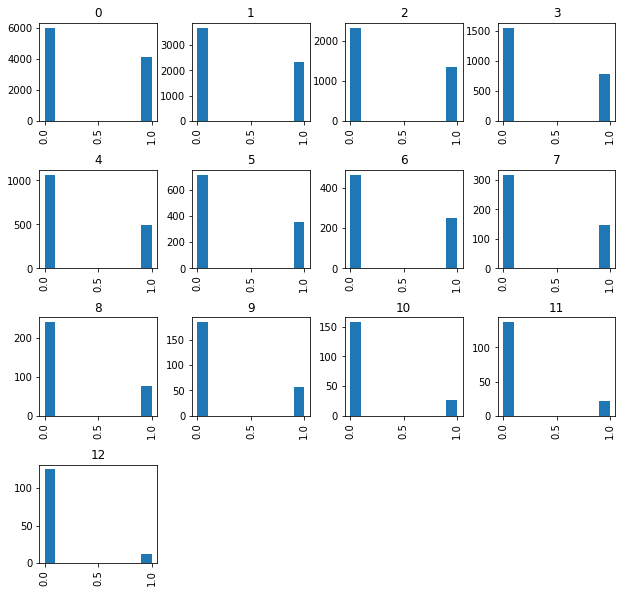

In [ ]:

df_week_12 = df_weekly_merged[df_weekly_merged["week"] <= 12]
df_week_12["last_week_of_activity"].astype(int).hist(by = df_week_12["week"],figsize = (10,10))

In [ ]:
labels_n

,user_id,dropout_at_week_n
0,387604,False
1,387605,False
2,387608,False
3,387615,False
4,387644,False
...,...,...
6000,404502,True
6001,404510,True
6002,404517,True
6003,404526,True


In [ ]:
# NaN values should be ignored by the Standarizer 
columns_to_standarize = ['num_events', 'num_questions', 'percentage_correct', 'num_theory']

def df_standarize(df):
    scaler = StandardScaler()
    df_stand = df.copy()
    df_stand[columns_to_standarize] = scaler.fit_transform(df[columns_to_standarize]) 
    return df_stand

df_weekly_stand = df_standarize(df_weekly_merged_n)
df_weekly_stand

,user_id,week,num_events,num_questions,percentage_correct,num_theory,last_week_of_activity
0,387604,0,-0.792108,-0.594629,NaN,-0.226180,False
1,387604,1,-0.792108,-0.594629,NaN,-0.226180,False
2,387605,0,-0.714310,-0.457031,1.026192,-0.226180,False
3,387605,1,-0.728455,-0.548763,-0.810337,-0.226180,False
4,387608,0,-0.141436,0.093359,1.577150,-0.226180,False
...,...,...,...,...,...,...,...
16065,404517,1,-0.707238,-0.594629,NaN,-0.226180,True
16067,404526,0,4.024277,3.946087,0.608799,0.133599,False
16068,404526,1,-0.650658,-0.548763,-0.810337,-0.226180,True
16070,404536,0,1.251850,-0.135971,1.944456,0.223544,False


In [ ]:
# USE THIS PIPELINE TO APPLY TRANSFORMATIONS TO ONLY SOME COLUMNS

# preprocessor = ColumnTransformer(
#     transformers=[('scaler', StandardScaler(), columns_to_standarize)],
#     remainder='passthrough'
# )

# pipeline = Pipeline([
#     ('preprocessor', preprocessor)
# ]) # add your model in pipeline

# pipeline.fit(THE_DATA)


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

##Neural Network: Long short-term memory 

Here is the architecture of the neural network we are using; it is very close to the one implemented for in the class notebook of week 8, as it is a simple neural network mainly composed of a number of LSTMs recurrent unit, and a dense layer with a sigmoid to have a prediction between 0 and 1.

In [ ]:
def create_model_lstm_mooc_binary(nb_features, nb_skills, params):
  
  # Create an LSTM model architecture.
  inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')

  # LSTM layer
  x = tf.keras.layers.LSTM(params['recurrent_units'], 
                            return_sequences=False, 
                            dropout=params['dropout_rate'])(inputs)
  
      
  # Dense layer with the sigmoid function 
  dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
  outputs = dense(x)
  model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='TimeSeries')

  # Compile the model
  model.compile(loss=tf.keras.losses.binary_crossentropy, 
                optimizer=params['optimizer'],
                metrics=[tf.keras.metrics.AUC(), 'binary_accuracy'])    
  return model



We then train 3 models on various subset of the data; The first only on week 1, the second on week 1 to 4, and the last to week 1 to 8. The goal is to train these models to recognize whether or not a user will drop the course at various stages of them using the learning platform.

###1st LSTM NN: Training on Week 1:

In [ ]:
#Parameters for the dataset of week 1:
#Number of weeks
n = 1         
#Number of features  
num_features = 4
#Take the weeks up to n
df_x, labels = week_up_to_n(df_weekly_merged, n)
#Fill missing values in the "percentage_correct" column (see report)
df_x.fillna(0, inplace = True)
#Standardization
df_x = df_standarize(df_x)
print(df_x.shape)
#Preparation of the input in the shape number of users * number of weeks * number of features
df_x_binary = df_x.drop(columns=["user_id","week","last_week_of_activity"]).values.reshape(-1, n, num_features)
print(df_x_binary.shape)
#Preparation of the labels in the shape number of users * boolean of if they dropped the course 
df_y_binary = labels.drop(columns=["user_id"]).values.reshape(-1, 1)

(10113, 7)
(10113, 1, 4)


In [ ]:
# Split into training and test sets.
df_x_binary_train_1, df_x_binary_test_1, df_y_binary_train_1, df_y_binary_test_1 = train_test_split(
                                                                            df_x_binary, 
                                                                            df_y_binary,
                                                                            test_size=0.2, 
                                                                            random_state=0, 
                                                                            stratify=df_y_binary)

# Split training into training and validation sets.
df_x_binary_train_val_1, df_x_binary_val_1, df_y_binary_train_val_1, df_y_binary_val_1 = train_test_split(
                                                                            df_x_binary_train_1, 
                                                                            df_y_binary_train_1, 
                                                                            test_size=0.2,
                                                                            random_state=0, 
                                                                            stratify=df_y_binary_train_1)

In [ ]:
#Parameters of the model
params = {}

params['batch_size'] = 32
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16
#The number of epoch is chosen according to how long an epoch takes to train, and how the network behaves;
#For a single week of around 10'000 users, 50 epochs are more than enough for the model to overfit
params['epochs'] = 50
params['dropout_rate'] = 0.1

In [ ]:
#Grid search on the number of recurrent units in the LSTM model, between 16 and 128
params_space = {param: [value] for param, value in params.items()}
params_space['recurrent_units'] = [16, 32, 64, 128]
params_grid = ParameterGrid(params_space)

In [ ]:
# Conduct the gridsearch over hyperparameters.
results_1 = {}

for params_i in params_grid:

  # Create a LSTM model with the specific parameter setting params_i
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)

  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)

  # Save the best version of the model through the training epochs
  ckp_callback = tf.keras.callbacks.ModelCheckpoint(save_model_name, 
                                                    save_best_only=True, save_weights_only=True)

  # Fit the model on the training data with the appropriate parameters  
  time_series_lstm.fit(df_x_binary_train_val_1, 
                        df_y_binary_train_val_1, 
                        epochs=params_i['epochs'],
                        validation_data=(df_x_binary_val_1, df_y_binary_val_1),
                        callbacks=[ckp_callback], 
                        verbose=params_i['verbose'])
  
#Once each model has been fully trained, evaluate their best version on the validation set to choose the best parameter
for params_i in params_grid:
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)
  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)
  time_series_lstm.load_weights(save_model_name)
  # Evaluate the model performance
  results_1[params_i['recurrent_units']] = time_series_lstm.evaluate(df_x_binary_val_1, 
                                                                    df_y_binary_val_1,
                                                                    verbose=params_i['verbose'], 
                                                                    return_dict=True)

Epoch 1/50
203/203 [==============================] - 4s 7ms/step - loss: 0.6848 - auc: 0.5013 - binary_accuracy: 0.5669 - val_loss: 0.6767 - val_auc: 0.5307 - val_binary_accuracy: 0.5952
Epoch 2/50
203/203 [==============================] - 1s 3ms/step - loss: 0.6760 - auc: 0.5040 - binary_accuracy: 0.5933 - val_loss: 0.6742 - val_auc: 0.5304 - val_binary_accuracy: 0.5939
Epoch 3/50
203/203 [==============================] - 1s 4ms/step - loss: 0.6746 - auc: 0.5136 - binary_accuracy: 0.5938 - val_loss: 0.6738 - val_auc: 0.5424 - val_binary_accuracy: 0.5939
Epoch 4/50
203/203 [==============================] - 1s 4ms/step - loss: 0.6740 - auc: 0.5206 - binary_accuracy: 0.5938 - val_loss: 0.6735 - val_auc: 0.5410 - val_binary_accuracy: 0.5939
Epoch 5/50
203/203 [==============================] - 1s 3ms/step - loss: 0.6732 - auc: 0.5326 - binary_accuracy: 0.5936 - val_loss: 0.6733 - val_auc: 0.5352 - val_binary_accuracy: 0.5952
Epoch 6/50
203/203 [==============================] - 1s 3ms

In [ ]:
# Sort candidate parameters according to their accuracy
results_sorted = sorted(results_1.items(), key=lambda x: x[1]['binary_accuracy'], reverse=True)
# Obtain the best parameters
best_params_1 = results_sorted[0][0]
best_params_1

32

###2nd LSTM NN: Training on Weeks 1 to 4:

In [ ]:
#Parameters for the dataset of weeks 1 to 4; same procedure as for week 1
n = 4
df_x, labels = week_up_to_n(df_weekly_merged, n)
df_x.fillna(0, inplace = True)
df_x = df_standarize(df_x)
df_x_binary = df_x.drop(columns=["user_id","week","last_week_of_activity"]).values.reshape(-1, n, num_features)
df_y_binary = labels.drop(columns=["user_id"]).values.reshape(-1, 1)

In [ ]:
# Split into training and test sets.
df_x_binary_train_4, df_x_binary_test_4, df_y_binary_train_4, df_y_binary_test_4 = train_test_split(
                                                                            df_x_binary, 
                                                                            df_y_binary,
                                                                            test_size=0.2, 
                                                                            random_state=0, 
                                                                            stratify=df_y_binary)

# Split training into training and validation sets.
df_x_binary_train_val_4, df_x_binary_val_4, df_y_binary_train_val_4, df_y_binary_val_4 = train_test_split(
                                                                            df_x_binary_train_4, 
                                                                            df_y_binary_train_4, 
                                                                            test_size=0.2,
                                                                            random_state=0, 
                                                                            stratify=df_y_binary_train_4)

In [ ]:
#Parameters of the model
params = {}

params['batch_size'] = 32
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16
#Here since we have less users in the dataset (as many dropped out during week 1 to 3), 
#epochs takes less time and we have to run more of them to have the network overfit
params['epochs'] = 200
params['dropout_rate'] = 0.1

In [ ]:
#Grid search on the number of recurrent units in the LSTM model, between 16 and 128
params_space = {param: [value] for param, value in params.items()}
params_space['recurrent_units'] = [16, 32, 64, 128]
params_grid = ParameterGrid(params_space)

In [ ]:
# Conduct the gridsearch over hyperparameters.
results_4 = {}

for params_i in params_grid:

  # Create a LSTM model with the specific parameter setting params_i
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)

  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)

  # Save the best version of the model through the training epochs
  ckp_callback = tf.keras.callbacks.ModelCheckpoint(save_model_name, 
                                                    save_best_only=True, save_weights_only=True)

  # Fit the model on the training data with the appropriate parameters  
  time_series_lstm.fit(df_x_binary_train_val_4, 
                        df_y_binary_train_val_4, 
                        epochs=params_i['epochs'],
                        validation_data=(df_x_binary_val_4, df_y_binary_val_4),
                        callbacks=[ckp_callback], 
                        verbose=params_i['verbose'])
#Once each model has been fully trained, evaluate their best version on the validation set to choose the best parameter
for params_i in params_grid:
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)
  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)
  time_series_lstm.load_weights(save_model_name)
  # Evaluate the model performance
  results_4[params_i['recurrent_units']] = time_series_lstm.evaluate(df_x_binary_val_4, 
                                                                    df_y_binary_val_4,
                                                                    verbose=params_i['verbose'], 
                                                                    return_dict=True)

Epoch 1/200
47/47 [==============================] - 3s 19ms/step - loss: 0.6719 - auc_8: 0.5693 - binary_accuracy: 0.5991 - val_loss: 0.6443 - val_auc_8: 0.6405 - val_binary_accuracy: 0.6542
Epoch 2/200
47/47 [==============================] - 0s 5ms/step - loss: 0.6428 - auc_8: 0.5821 - binary_accuracy: 0.6568 - val_loss: 0.6208 - val_auc_8: 0.6385 - val_binary_accuracy: 0.6676
Epoch 3/200
47/47 [==============================] - 0s 5ms/step - loss: 0.6303 - auc_8: 0.5700 - binary_accuracy: 0.6662 - val_loss: 0.6135 - val_auc_8: 0.6391 - val_binary_accuracy: 0.6676
Epoch 4/200
47/47 [==============================] - 0s 5ms/step - loss: 0.6244 - auc_8: 0.5897 - binary_accuracy: 0.6662 - val_loss: 0.6119 - val_auc_8: 0.6399 - val_binary_accuracy: 0.6676
Epoch 5/200
47/47 [==============================] - 0s 5ms/step - loss: 0.6234 - auc_8: 0.5856 - binary_accuracy: 0.6662 - val_loss: 0.6113 - val_auc_8: 0.6423 - val_binary_accuracy: 0.6676
Epoch 6/200
47/47 [=========================

In [ ]:
# Sort candidate parameters according to their accuracy
results_sorted = sorted(results_4.items(), key=lambda x: x[1]['binary_accuracy'], reverse=True)

# Obtain the best parameters
best_params_4 = results_sorted[0][0]
best_params_4

16

###3rd LSTM NN: Training on Weeks 1 to 8: 

In [ ]:
#Parameters for the dataset of weeks 1 to 8; same procedure as for week 1 and weeks 1 to 4
n = 8
df_x, labels = week_up_to_n(df_weekly_merged, n)
df_x.fillna(0, inplace = True)
df_x = df_standarize(df_x)
df_x_binary = df_x.drop(columns=["user_id","week","last_week_of_activity"]).values.reshape(-1, n, num_features)
df_y_binary = labels.drop(columns=["user_id"]).values.reshape(-1, 1)

In [ ]:
# Split into training and test sets.
df_x_binary_train_8, df_x_binary_test_8, df_y_binary_train_8, df_y_binary_test_8 = train_test_split(
                                                                            df_x_binary, 
                                                                            df_y_binary,
                                                                            test_size=0.2, 
                                                                            random_state=0, 
                                                                            stratify=df_y_binary)

# Split training into training and validation sets.
df_x_binary_train_val_8, df_x_binary_val_8, df_y_binary_train_val_8, df_y_binary_val_8 = train_test_split(
                                                                            df_x_binary_train_8, 
                                                                            df_y_binary_train_8, 
                                                                            test_size=0.2,
                                                                            random_state=0, 
                                                                            stratify=df_y_binary_train_8)

In [ ]:
#Parameters of the model
params = {}

params['batch_size'] = 32
params['verbose'] = 1
params['best_model_weights'] = 'weights/bestmodel' 
params['optimizer'] = 'adam'
params['recurrent_units'] = 16
#Same principle as for weeks 1 to 4; less users means faster epoch, and we have to 
#run more f them for the model to overfit
params['epochs'] = 500
params['dropout_rate'] = 0.1

In [ ]:
#Grid search on the number of recurrent units in the LSTM model, between 16 and 128
params_space = {param: [value] for param, value in params.items()}
params_space['recurrent_units'] = [16, 32, 64, 128]
params_grid = ParameterGrid(params_space)

In [ ]:
# Conduct the gridsearch over hyperparameters.
results_8 = {}

for params_i in params_grid:

  # Create a LSTM model with the specific parameter setting params_i
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)

  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)

  # Save the best version of the model through the training epochs
  ckp_callback = tf.keras.callbacks.ModelCheckpoint(save_model_name, 
                                                    save_best_only=True, save_weights_only=True)

  # Fit the model on the training data with the appropriate parameters  
  time_series_lstm.fit(df_x_binary_train_val_8, 
                        df_y_binary_train_val_8, 
                        epochs=params_i['epochs'],
                        validation_data=(df_x_binary_val_8, df_y_binary_val_8),
                        callbacks=[ckp_callback], 
                        verbose=params_i['verbose'])
#Once each model has been fully trained, evaluate their best version on the validation set to choose the best parameter
for params_i in params_grid:
  time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params_i)
  save_model_name = params_i['best_model_weights'] + "_" + str(params_i['recurrent_units']) + "_" + str(n)
  time_series_lstm.load_weights(save_model_name)
  # Evaluate the model performance
  results_8[params_i['recurrent_units']] = time_series_lstm.evaluate(df_x_binary_val_8, 
                                                                    df_y_binary_val_8,
                                                                    verbose=params_i['verbose'], 
                                                                    return_dict=True)

Epoch 1/500
10/10 [==============================] - 4s 142ms/step - loss: 0.6844 - auc_16: 0.5672 - binary_accuracy: 0.5743 - val_loss: 0.6800 - val_auc_16: 0.5601 - val_binary_accuracy: 0.7027
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6697 - auc_16: 0.5901 - binary_accuracy: 0.6622 - val_loss: 0.6657 - val_auc_16: 0.5823 - val_binary_accuracy: 0.6892
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6565 - auc_16: 0.6184 - binary_accuracy: 0.6892 - val_loss: 0.6541 - val_auc_16: 0.6019 - val_binary_accuracy: 0.6892
Epoch 4/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6421 - auc_16: 0.6428 - binary_accuracy: 0.6858 - val_loss: 0.6429 - val_auc_16: 0.6027 - val_binary_accuracy: 0.6892
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6301 - auc_16: 0.6474 - binary_accuracy: 0.6824 - val_loss: 0.6317 - val_auc_16: 0.6053 - val_binary_accuracy: 0.6892
Epoch 6/500
10/10 [=============

In [33]:
# Sort candidate parameters according to their accuracy
results_sorted = sorted(results_8.items(), key=lambda x: x[1]['binary_accuracy'], reverse=True)

# Obtain the best parameters
best_params_8 = results_sorted[0][0]
best_params_8

16

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

##Evaluating the LSTMs models:
After training the models and selecting the best hyperparameters, we evaluate the models performances on their respective test set. Note that as the data is sorted, and the splits are done deterministically with a seed, the train-validation-test sets always have the same samples for a given number of week, and so we can compare the models with the decision trees directly.

###Model trained on Week 1:

In [38]:
# Load the best version of the the trained model and evaluate its performance on the test_set.
params['recurrent_units'] = best_params_1
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)
time_series_lstm.load_weights(params['best_model_weights'] + "_" + str(best_params_1) + "_1")

predictions = time_series_lstm.predict(df_x_binary_test_1)
bac = balanced_accuracy_score(df_y_binary_test_1, predictions>0.5)
auc = roc_auc_score(df_y_binary_test_1,predictions)
ac = accuracy_score(df_y_binary_test_1, predictions>0.5)
pr = precision_score(df_y_binary_test_1, predictions>0.5)
re = recall_score(df_y_binary_test_1, predictions>0.5)
print("Balanced accuracy: ", bac)
print("AUC: ", auc)
print("Accuracy: ", ac)
print("Precision: ", pr)
print("Recall: ", re)

Balanced accuracy:  0.5177644947134484
AUC:  0.5525808784650261
Accuracy:  0.6040533860603065
Precision:  0.6438356164383562
Recall:  0.057177615571776155


In [35]:
print("Mean predictions: {}".format(predictions.mean()))
print("Std deviation of  predictions: {}".format(predictions.std()))

Mean predictions: 0.4081825613975525
Std deviation of  predictions: 0.040732547640800476


###Model trained on Weeks 1 to 4

In [39]:
# Load the best version of the the trained model and evaluate its performance on the test_set.
params['recurrent_units'] = best_params_4
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)
time_series_lstm.load_weights(params['best_model_weights'] + "_" + str(best_params_4) + "_4")

predictions = time_series_lstm.predict(df_x_binary_test_4)
bac = balanced_accuracy_score(df_y_binary_test_4, predictions>0.5)
auc = roc_auc_score(df_y_binary_test_4,predictions)
ac = accuracy_score(df_y_binary_test_4, predictions>0.5)
pr = precision_score(df_y_binary_test_4, predictions>0.5)
re = recall_score(df_y_binary_test_4, predictions>0.5)

print("Balanced accuracy: ", bac)
print("AUC: ", auc)
print("Accuracy: ", ac)
print("Precision: ", pr)
print("Recall: ", re)

Balanced accuracy:  0.5146354112643916
AUC:  0.5955606264910278
Accuracy:  0.6523605150214592
Precision:  0.41025641025641024
Recall:  0.1032258064516129


In [40]:
print("Mean predictions: {}".format(predictions.mean()))
print("Std deviation of  predictions: {}".format(predictions.std()))

Mean predictions: 0.32320526242256165
Std deviation of  predictions: 0.131057471036911


###Model trained on Weeks 1 to 8

In [41]:
# Load the best version of the the trained model and evaluate its performance on the test_set.
params['recurrent_units'] = best_params_8
time_series_lstm = create_model_lstm_mooc_binary(num_features, 1, params)
time_series_lstm.load_weights(params['best_model_weights'] + "_" + str(best_params_8) + "_8")

predictions = time_series_lstm.predict(df_x_binary_test_8)
bac = balanced_accuracy_score(df_y_binary_test_8, predictions>0.5)
auc = roc_auc_score(df_y_binary_test_8,predictions)
ac = accuracy_score(df_y_binary_test_8, predictions>0.5)
pr = precision_score(df_y_binary_test_8, predictions>0.5)
re = recall_score(df_y_binary_test_8, predictions>0.5)

print("Balanced accuracy: ", bac)
print("AUC: ", auc)
print("Accuracy: ", ac)
print("Precision: ", pr)
print("Recall: ", re)

Balanced accuracy:  0.5942887931034483
AUC:  0.7516163793103449
Accuracy:  0.6881720430107527
Precision:  0.5
Recall:  0.3448275862068966


In [42]:
print("Mean predictions: {}".format(predictions.mean()))
print("Std deviation of  predictions: {}".format(predictions.std()))

Mean predictions: 0.28622785210609436
Std deviation of  predictions: 0.22790734469890594


###LSTM Models Analysis:
Overall, the models didn't perform very well. 

On week 1, it is barely better than a random model on almost all metrics. It clearly struggles to make confident predictions, as it has a mean prediction very close to the mean data with a low standard deviation. Moreover, the slightly higher precision and accuracy is likely only due to the class imbalance of the dataset. 

On week 1 to 4, it is slightly better, with better AUC, accuracy and recall, at the cost of precision. 

In [ ]:
 #!zip -r weights.zip weights/ 